# Homework 3: Visualizing Data with Movies

Name: Harsita Keerthikanth

Date: 2/10/2025

#### Overview
In this homework, you'll create a movie visualization of a model parameter such as temperature, salinity, velocity, or any other field which may be of interest to you. 

As an example, I've provided a movie of circulation in the Equatorial Pacific from the NASA ECCO Version 5 State Estimate. For the purposes of this visualization, I subsetted the Equatorial Pacific is the region between 155-75$^{\circ}$W and $\pm$20$^{\circ}$N.

#### Import Modules
Import the modules required to access data from netCDF files, plot it, and stitch panels together into a movie:

In [1]:
# import modules here
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cm
import moviepy.video.io.ImageSequenceClip

## Part 1: Download Data
To begin this exercise, download all of the available data for your variable of interest over the timespan of interest.

For the example provided, I've used daily sea surface temperature data for a given year (2015) from the ECCO Version 5 Alpha output [HERE](https://ecco.jpl.nasa.gov/drive/files/Version5/Alpha/latlon_daily/SST.nc).

To obtain your data, use the [Downloading ECCO Data](https://github.com/ProfMikeWood/ocean_modeling_book/blob/main/tools/Downloading%20ECCO%20Data.ipynb) notebook provided with the course notes. Be sure to edit the fields to obtain the correct data.

In [2]:
# define the path to the data folder
data_folder = '/Users/harsita/Desktop/sjsu/year 3/spring 25/cs 185c - ocean modeling/data'

## Part 2: Create a Single Plot of Sea Surface Temperature
Before making a movie, its useful to fine tune a single plot to get the details right. Once you've got your plot lookin' good, you can loop through all of the data to generate the panels of your movie.

Here, make a plot of one variable field. 

Begin by reading in the longitude, latitude, and SST fields from the netCDF file:

In [3]:
# read in the data
# make a path to a sea ice file
salt_file = os.path.join(data_folder,'ECCO','Version5','Alpha',
                          'latlon_daily','SSS','SSS_20150101.nc')

# read in the salt data at along with the
# latitude and longitude information 
ds = xr.open_dataset(salt_file, decode_times=False)
longitude = np.array(ds['LONGITUDE_T'][:])
latitude = np.array(ds['LATITUDE_T'][:])
salt = np.array(ds['SSS'][:])
ds.close()

# subset salt to the first time step
SSS = salt[0, :, :]

Next, find the locations of the longitude and latitude bounds within the global grid for your region of interest:

In [4]:
# define the longitude/latitude bounds
min_lon = 20
max_lon = 120
min_lat = -40
max_lat = 30

# compute the min/max row/col in the data grid
min_row = np.argmin(np.abs(latitude - min_lat))
max_row = np.argmin(np.abs(latitude - max_lat))
min_col = np.argmin(np.abs(longitude - min_lon))
max_col = np.argmin(np.abs(longitude - max_lon))

Use the row and column bounds to subset the longitude, latitude, and your variable:

In [5]:
# subset the data
# subset longitude and latitude arrays
subset_longitude = longitude[min_col:max_col]
subset_latitude = latitude[min_row:max_row]

# subset salt data for the region 
subset_SSS = SSS[min_row:max_row, min_col:max_col]

/opt/miniconda3/envs/cs185c/lib/python3.12/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/miniconda3/envs/cs185c/lib/python3.12/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


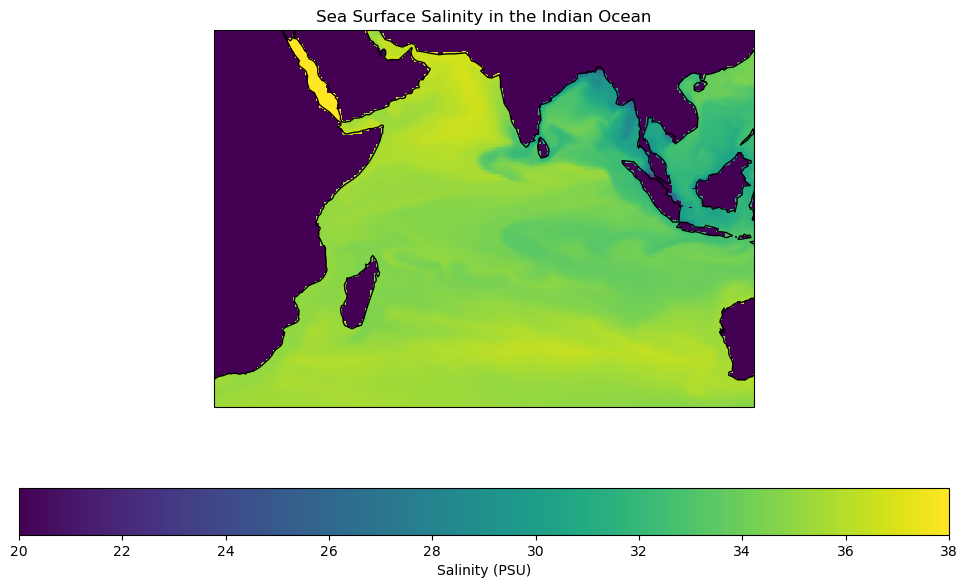

In [6]:
# make your figure here
# convert longitude from [0, 360] to [-180, 180] 
subset_longitude = np.where(subset_longitude > 180, subset_longitude - 360, subset_longitude)
subset_SSS = np.nan_to_num(subset_SSS, nan=0)

# create meshgrid
longitude_grid, latitude_grid = np.meshgrid(subset_longitude, subset_latitude)

# create figure
fig, ax = plt.subplots(figsize=(12, 7), subplot_kw={'projection': ccrs.PlateCarree()})

# set map extent
ax.set_extent([subset_longitude.min(), subset_longitude.max(),
                   subset_latitude.min(), subset_latitude.max()], crs=ccrs.PlateCarree())

# plot salinity data
salt_plot = ax.pcolormesh(longitude_grid, latitude_grid, subset_SSS, 
                              vmin=20, vmax=38, cmap='viridis', shading='nearest')

# add coastlines
ax.coastlines()

# add color bar
plt.colorbar(salt_plot, ax=ax, orientation='horizontal', label='Salinity (PSU)')

# add labels and title
plt.title(f"Sea Surface Salinity in the Indian Ocean")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

## Part 3: Formulate a Plotting Function
When you are happy with your plot, make your code into a function that will take the year, month, and day as inputs, and output the figure into a given directory. 

In [7]:
def plot_panel(year, month, day, output_dir="plots"):

    # construct file path
    salt_file = os.path.join(data_folder, "ECCO", "Version5", "Alpha",
                             "latlon_daily", "SSS", f"SSS_{year}{month:02d}{day:02d}.nc")
    
    # check if file exists
    if not os.path.exists(salt_file):
        print(f"Error: File {salt_file} not found.")
        return

    # load dataset with decode_times=False
    ds = xr.open_dataset(salt_file, decode_times=False)

    # extract longitude, latitude, and salinity data
    longitude = np.array(ds['LONGITUDE_T'][:])
    latitude = np.array(ds['LATITUDE_T'][:])
    salt = np.array(ds['SSS'][:]) 

    SSS = salt[0, :, :]
    
    ds.close()

    # define region bounds for indian ocean
    min_lon, max_lon = 20, 120
    min_lat, max_lat = -40, 30

    # find indices for the subset region
    min_col = np.argmin(np.abs(longitude - min_lon))
    max_col = np.argmin(np.abs(longitude - max_lon)) + 1  # ensure one extra for pcolormesh
    min_row = np.argmin(np.abs(latitude - min_lat))
    max_row = np.argmin(np.abs(latitude - max_lat)) + 1  # ensure one extra for pcolormesh

    # subset data
    subset_longitude = longitude[min_col:max_col]
    subset_latitude = latitude[min_row:max_row]
    subset_SSS = salt[0, min_row:max_row-1, min_col:max_col-1]  # ensure it aligns
    
    subset_SSS = np.nan_to_num(subset_SSS, nan=0)

    # convert longitude from [0, 360] to [-180, 180] 
    subset_longitude = np.where(subset_longitude > 180, subset_longitude - 360, subset_longitude)

    # create meshgrid
    longitude_grid, latitude_grid = np.meshgrid(subset_longitude, subset_latitude)

    # create figure
    fig, ax = plt.subplots(figsize=(12, 7), subplot_kw={'projection': ccrs.PlateCarree()})

    # set map extent
    ax.set_extent([subset_longitude.min(), subset_longitude.max(),
                   subset_latitude.min(), subset_latitude.max()], crs=ccrs.PlateCarree())

    # plot salinity data
    salt_plot = ax.pcolormesh(longitude_grid, latitude_grid, subset_SSS, 
                              vmin=28, vmax=38, cmap='viridis', shading='nearest')

    # add coastlines
    ax.coastlines()

    # add color bar
    plt.colorbar(salt_plot, ax=ax, orientation='horizontal', label='Salinity (PSU)')

    # add labels and title
    plt.title(f"Sea Surface Salinity in the Indian Ocean ({year}-{month:02d}-{day:02d})")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    # plt.show()
    
    # ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # save figure
    output_path = os.path.join(output_dir, f"SSS_{year}{month:02d}{day:02d}.png")
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()
    

# test call
plot_panel(2015, 5, 12) 

/opt/miniconda3/envs/cs185c/lib/python3.12/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/miniconda3/envs/cs185c/lib/python3.12/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/miniconda3/envs/cs185c/lib/python3.12/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


Once the function is complete, use it to loop through all of the data to make a plot for each day of the year. The following lines of code will form the panels of a data visualization movie when using daily data. If you are using monthly data, update accordingly:

In [ ]:
# loop through the data and make a plot for each day
year = 2015
for month in range(1,13):
    if month in [1,3,5,7,8,10,12]:
        n_days = 31
    elif month in [4,6,9,11]:
        n_days = 30
    else:
        if year%4==0:
            n_days = 29
        else:
            n_days = 28
    for day in range(1,n_days+1):
        plot_panel(year,month,day)

/opt/miniconda3/envs/cs185c/lib/python3.12/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/miniconda3/envs/cs185c/lib/python3.12/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/miniconda3/envs/cs185c/lib/python3.12/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/miniconda3/envs/cs185c/lib/python3.12/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/miniconda3/envs/cs185c/lib/python3.12/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/miniconda3/envs/cs185c/lib/python3.12/site-packages/shapely/predicates.py:778: RuntimeWarning: 

## Part 4: Compile Panels into a Movie
After creating all of the panels, stitch them together into a movie using moviepy:

In [ ]:
# make a list of files for each movie panel
output_dir = "plots" 
panel_files = [os.path.join(output_dir, f) for f in os.listdir(output_dir) if f.endswith('.png')]

# sort the panels
panel_files.sort()

In [ ]:
# set the frames per second
fps = 5

# use the ImageSequenceClip module to set up the clip
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(panel_files, fps=fps)

# write the video to a file
clip.write_videofile('Indian Ocean Salinity.mp4')

## Part 5: Interpret Features in the Movie
A movie gives a good visualization of the physical processes occurring in a model. Describe one feature you see in the movie and relate it to an oceanographic feature. It could be a feature discussed in class or another feature you noticed and researched on your own.

Answer: 
Salinity in the Indian Ocean is seems to be closely linked to the monsoon season, with the monsoon bringing heavy rainfall during the summer and fall months. This increased precipitation dilutes surface waters, particularly in the Bay of Bengal and Arabian Sea, lowering the salinity in coastal regions. During the monsoon, river runoff could further reduces salinity near the coast. The movie shows surface ocean near the coast having a lower PSU during the monsoon season. Conversely, during the post monsoon period, reduced rainfall and increased evaporation lead to a rise in salinity, especially in the Arabian Sea, shown by higher PSU during those times. These seasonal changes in salinity due to the monsoons are shown in the movie. Other physical or climate changes could also impact the salinity near the Indian Ocean.